In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from bs4 import BeautifulSoup
import requests
import math
import random
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_optimization_history
optuna.logging.set_verbosity(optuna.logging.WARNING)

#Regression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
import lightgbm
from xgboost import plot_importance, plot_tree
from matplotlib import pyplot
from sklearn.model_selection import learning_curve
from yellowbrick.model_selection import LearningCurve

#Cluster
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from scipy import stats

import warnings 
warnings.filterwarnings('ignore')

In [6]:
v_spec = pd.read_csv('vehicle_spec')
v_spec.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
v = v_spec.drop([14,47]).reset_index(drop=True)
v

,Brand,Model,Battery,0 - 100,Top Speed,Range,Efficiency,Fastcharge,Price(German)
0,Nissan,Leaf,37.0,7.9,144,225,164,230.0,29990.0
1,Porsche,Taycan Turbo S,83.7,2.8,260,390,215,860.0,186336.0
2,Nissan,e-NV200 Evalia,37.0,14.0,123,170,218,170.0,43730.0
3,Nissan,Leaf e+,56.0,7.3,157,325,172,390.0,37550.0
4,BMW,i3 120 Ah,37.9,7.3,150,235,161,270.0,39000.0
...,...,...,...,...,...,...,...,...,...
165,Peugeot,e-208,45.0,8.1,150,285,158,460.0,31950.0
166,Peugeot,e-2008 SUV,45.0,8.5,150,255,176,410.0,35450.0
167,Opel,Corsa-e,45.0,8.1,150,285,158,460.0,29900.0
168,Opel,Mokka-e,45.0,9.2,150,255,176,410.0,34110.0


In [363]:
# Log Scaling as a Normalization Technique
X = np.log(v.iloc[:,2:8]) #Specifications of vehicle
y = np.log(v['Price(German)']) # Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Decision Tree Regressor

In [240]:
# Decision Tree Default
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)

DecisionTreeRegressor()

In [241]:
y_pred = dt.predict(X_test)
print(r2_score(y_test,y_pred))

0.5854992496175708


### Hyperparameter Tuning with GridSearch

In [243]:
cv = ShuffleSplit(n_splits=5, test_size=0.2,random_state=42)

In [244]:
parameter = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
             'splitter' :['best', 'random'],
             'max_depth': [None, 1, 3, 5, 7, 10],
            'min_samples_split': [i for i in range(1,15,1)]}

In [245]:
# Hyperparameter Tuning with Default cross validation method - KFold Cross Validation
grid = GridSearchCV(DecisionTreeRegressor(), param_grid= parameter, scoring='r2', cv=cv)
grid.fit(X_train,y_train)
print(grid.best_estimator_)
print(grid.best_score_)

DecisionTreeRegressor(criterion='poisson', max_depth=10, min_samples_split=12,
                      splitter='random')
0.7673296937593245


In [246]:
# Prediction using the Tunned hyperparameter
# Score is comparably higher than the K-Fold Model
y_pred_gs = grid.predict(X_test)
print('Accuracy Score {}'.format(r2_score(y_test,y_pred_gs) * 100))

Accuracy Score 56.735883486698704


### Hyperparameter Tuning with RandomSearch

In [247]:
parameter = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
             'max_depth': [None, 1, 5, 10, 15, 20],
            'min_samples_split': [2, 4, 6, 8, 10, 12],
            'min_samples_leaf': [1, 3, 5, 7, 10 , 12]}

In [248]:
rf_cv = RandomizedSearchCV(DecisionTreeRegressor(), parameter, 
n_iter =100, cv=cv, scoring='r2', refit=True )

In [249]:
result = rf_cv.fit(X_train, y_train)
print('Best Estimators: %s' % result.best_estimator_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % result.best_score_)

Best Estimators: DecisionTreeRegressor(criterion='poisson', max_depth=20, min_samples_leaf=3,
                      min_samples_split=4)
Best Hyperparameters: {'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 20, 'criterion': 'poisson'}
Best Score: 0.769014822087111


In [250]:
y_pred_rs = result.predict(X_test)
print('accuracy score: {}' .format(r2_score(y_test, y_pred) * 100))

accuracy score: 58.549924961757085


### Hyperparameter Tuning with Optuna

In [265]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion',['squared_error', 'friedman_mse', 'absolute_error', 'poisson'])
    max_depth = trial.suggest_int('max_depth', 1 , 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    
    classifier_obj = DecisionTreeRegressor(max_depth = max_depth, criterion = criterion, min_samples_split = min_samples_split,
                                          min_samples_leaf = min_samples_leaf)
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs = -1, cv = cv)
    accuracy = score.mean()
    
    return accuracy

In [266]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 20)
print("\n\nBEST PARAMETERS : \n",study.best_params)

[W 2021-12-10 12:34:11,031] Trial 0 failed, because the objective function returned nan.
[W 2021-12-10 12:34:11,044] Trial 1 failed, because the objective function returned nan.
[W 2021-12-10 12:34:11,077] Trial 3 failed, because the objective function returned nan.
[W 2021-12-10 12:34:11,091] Trial 4 failed, because the objective function returned nan.
[W 2021-12-10 12:34:11,120] Trial 6 failed, because the objective function returned nan.
[W 2021-12-10 12:34:11,134] Trial 7 failed, because the objective function returned nan.
[W 2021-12-10 12:34:11,160] Trial 9 failed, because the objective function returned nan.
[W 2021-12-10 12:34:11,173] Trial 10 failed, because the objective function returned nan.
[W 2021-12-10 12:34:11,186] Trial 11 failed, because the objective function returned nan.
[W 2021-12-10 12:34:11,201] Trial 12 failed, because the objective function returned nan.
[W 2021-12-10 12:34:11,216] Trial 13 failed, because the objective function returned nan.
[W 2021-12-10 12:



BEST PARAMETERS : 
 {'criterion': 'poisson', 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 3}


In [255]:
plot_optimization_history(study)

In [256]:
plot_param_importances(study)

In [267]:
p = study.best_params
dt_opt = DecisionTreeRegressor(**p)
dt_opt.fit(X_train,y_train)

y_pred_opt = dt_opt.predict(X_test)

print('Accuracry Score {}'.format(r2_score(y_test, y_pred_opt) * 100))

Accuracry Score 62.58966048866932


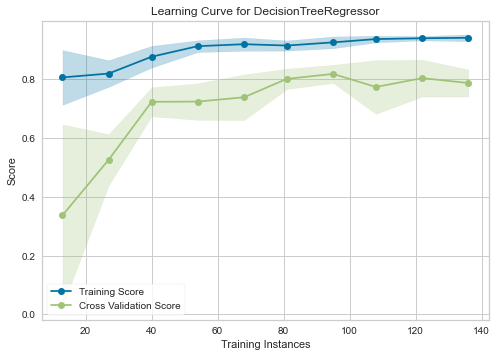

In [258]:
# Visualizing the Learning curve to see what is actually happening to the cross validation score 
visualizer = LearningCurve(DecisionTreeRegressor(**p)
                           ,scoring='r2', cv = cv,
                          train_sizes=np.linspace(0.1, 1.0, 10))
visualizer.fit(X, y)
visualizer.show()

#### Based on the methods we identified here:
1. Optuna Hyperparamter Tuning method showed the best score improvement
2. Cross Validation method: Shuffle Split 10 fold 
3. Learning Curve shows an increase in Training and Validation score as the training size increases, however the gap betwwen the two doesn't converge and therefore more data samples are required to improve the score 

## Random Forest

In [263]:
#Default RF
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(r2_score(y_test,y_pred_rf))

0.7645355519839611


In [320]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators',100, 1000)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'poisson'])
    max_depth = trial.suggest_int('max_depth', 1 , 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    
    classifier_obj = RandomForestRegressor(n_estimators = n_estimators, criterion = criterion, min_samples_split = min_samples_split,
                                          min_samples_leaf = min_samples_leaf)
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs = -1, cv = cv)
    accuracy = score.mean()
    
    return accuracy

In [321]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials = 20)
print("\n\nBEST PARAMETERS : \n",study_rf.best_params)

[W 2021-12-10 15:25:55,117] Trial 1 failed, because the objective function returned nan.
[W 2021-12-10 15:25:55,391] Trial 2 failed, because the objective function returned nan.
[W 2021-12-10 15:25:57,514] Trial 5 failed, because the objective function returned nan.
[W 2021-12-10 15:25:57,746] Trial 6 failed, because the objective function returned nan.
[W 2021-12-10 15:25:58,657] Trial 8 failed, because the objective function returned nan.
[W 2021-12-10 15:25:59,634] Trial 10 failed, because the objective function returned nan.
[W 2021-12-10 15:25:59,844] Trial 11 failed, because the objective function returned nan.
[W 2021-12-10 15:26:03,054] Trial 16 failed, because the objective function returned nan.
[W 2021-12-10 15:26:03,563] Trial 17 failed, because the objective function returned nan.
[W 2021-12-10 15:26:04,835] Trial 19 failed, because the objective function returned nan.




BEST PARAMETERS : 
 {'n_estimators': 302, 'criterion': 'poisson', 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}


In [322]:
def accuracy(parameters, model, X_train, y_train, X_test, y_test):
    tunned = model(**parameters)
    tunned.fit(X_train, y_train)
    
    y_pred = tunned.predict(X_test)
    
    print('MSE:{}'.format(mean_squared_error(y_test, y_pred)))
    print('RMSE:{}'.format(math.sqrt(mean_squared_error(y_test, y_pred))))
    print('MAE:{}'.format(mean_absolute_error(y_test,y_pred)))
    print('Accuracry Score {}'.format(r2_score(y_test, y_pred) * 100))

In [323]:
accuracy(study_rf.best_params, RandomForestRegressor, X_train, y_train, X_test, y_test)

MSE:0.07412879900871235
RMSE:0.272266044538632
MAE:0.1930357916480679
Accuracry Score 67.3228027808864


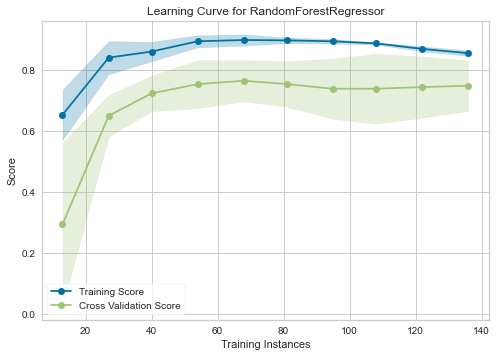

In [324]:
visualizer = LearningCurve(RandomForestRegressor(**study_rf.best_params),
                            scoring = 'r2',cv=cv,
                           train_sizes=np.linspace(0.1, 1.0, 10))
visualizer.fit(X,y)
visualizer.show()

RandomForest Learning Curve Interpretation,
* There is a gap between the Training and Testing dataset 
* Increasing the Training instances gradually increases the Validation Score
Hyperparameter Tuning Resulted in lower score, meaning it the tunned model performs not better than the default or because the training data was not sufficient (since the dataset is very small), the test dataset contained samples that are harder for tunned model to predict

## Gradient Boosting

In [325]:
# Gradient boosting has about 10% more accuracy than Decision tree (81%)
# But this also could be overfitting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train,y_train)
y_gb = gb.predict(X_test)
r2_score(y_test,y_gb)

0.7929968876521458

In [330]:
def objective_gb(trial):
    loss = trial.suggest_categorical('loss',['squared_error', 'absolute_error', 'huber','quantile'])
    n_estimators = trial.suggest_int('n_estimators',100,1000)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.5)
    max_depth = trial.suggest_int('max_depth', 3 , 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    
    classifier_obj = GradientBoostingRegressor(loss = loss, learning_rate=learning_rate, n_estimators = n_estimators, min_samples_split = min_samples_split,
                                          min_samples_leaf = min_samples_leaf)
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs = -1, cv = cv)
    accuracy = score.mean()
    
    return accuracy

In [331]:
study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials = 20)
print("\n\nBEST PARAMETERS : \n",study_gb.best_params)

[W 2021-12-10 15:50:29,438] Trial 6 failed, because the objective function returned nan.
[W 2021-12-10 15:50:29,452] Trial 7 failed, because the objective function returned nan.
[W 2021-12-10 15:50:31,893] Trial 11 failed, because the objective function returned nan.
[W 2021-12-10 15:50:31,909] Trial 12 failed, because the objective function returned nan.
[W 2021-12-10 15:50:31,925] Trial 13 failed, because the objective function returned nan.
[W 2021-12-10 15:50:34,650] Trial 15 failed, because the objective function returned nan.
[W 2021-12-10 15:50:34,677] Trial 16 failed, because the objective function returned nan.
[W 2021-12-10 15:50:34,706] Trial 17 failed, because the objective function returned nan.
[W 2021-12-10 15:50:34,733] Trial 18 failed, because the objective function returned nan.
[W 2021-12-10 15:50:34,760] Trial 19 failed, because the objective function returned nan.




BEST PARAMETERS : 
 {'loss': 'huber', 'n_estimators': 968, 'learning_rate': 0.44483255273564026, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 7}


In [332]:
accuracy(study_gb.best_params, GradientBoostingRegressor, X_train, y_train, X_test, y_test)

MSE:0.06492791739698735
RMSE:0.2548095708504438
MAE:0.1715849864525166
Accuracry Score 71.37870314669048


In [335]:
#Because Gradient boosting is considered to be a advanced version of decision tree(Also there are other tree models)
#We want to see if the Gradient boosting has different cross validation score
param = {'loss': ['squared_error','ls','huber'],
        'n_estimators': [100, 200],
         'criterion': ['friedman_mse','mse', 'mae'],
        'learning_rate': [0.05, 0.1]}

# Shufflesplit is used for cv method
grid_gb = GridSearchCV(GradientBoostingRegressor(),param_grid=param,cv=cv,scoring='r2',refit=True)
grid_gb.fit(X_train,y_train)
print(grid_gb.best_score_)
print(grid_gb.best_estimator_)
print(grid_gb.best_params_)

# We see that with the tunned hyperparameter, the score is high + CV score is stable
y_hat_gb = grid_gb.predict(X_test)
r2_score(y_test,y_hat_gb)

0.773382866892584
GradientBoostingRegressor(criterion='mse', loss='huber', n_estimators=200)
{'criterion': 'mse', 'learning_rate': 0.1, 'loss': 'huber', 'n_estimators': 200}


0.8015088104440233

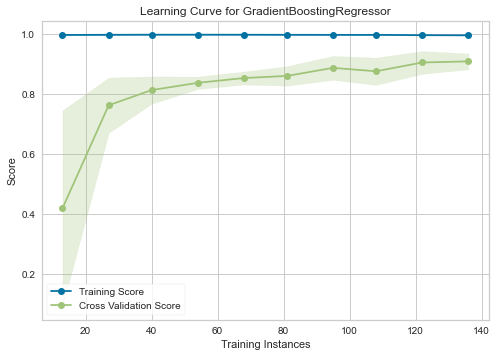

In [338]:
# Learning curve has negative score at the start (with the low training samples)
visualizer_gb = LearningCurve(GradientBoostingRegressor(**grid_gb.best_params_)
                              , scoring = 'r2',cv=cv ,train_sizes=np.linspace(0.1, 1.0, 10))

visualizer_gb.fit(X,y)
visualizer_gb.show()

High variability therefore seeing overfitting (Training score is staying high) but more data will benefit the model and including the regularization to lower the variablity will make a better model 

## XGBoost 

In [364]:
xg = xgb.XGBRegressor()
xg.fit(X_train,y_train,
       
       eval_set = [(X_train, y_train),(X_test, y_test)], #Dataset to evaluate each iteration
       eval_metric = 'rmse', #Evaluation Metrics - Any type of Regression eval metrics can work (Ex. MAE)
       early_stopping_rounds=10, #Early Stop allow prevention of overfitting 
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [365]:
# Prediction Score
y_xg = xg.predict(X_test)
r2_score(y_test,y_xg)

0.785776961627539

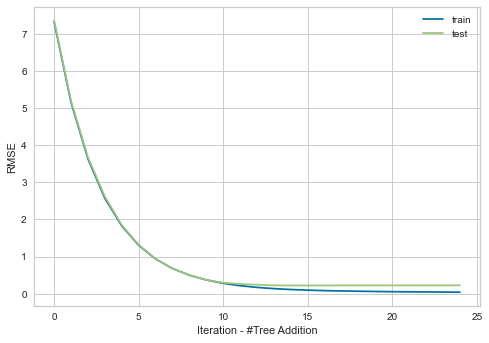

In [366]:
# Plotting Learning Curve
results = xg.evals_result()
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.xlabel('Iteration - #Tree Addition')
pyplot.ylabel('RMSE')
pyplot.show()

Adding more trees resuls in increasing the gap between train and test error. 
Indication of overfitting 

In [342]:
param = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.1),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45)}
xg_p = RandomizedSearchCV(xg, param_distributions = param, n_iter = 25, scoring = 'r2', error_score = 0, verbose = 3, n_jobs = -1)

#Hyperparameter Tuning 
n = 5
k = KFold(n_splits=n, shuffle=True)

estimators = []
results = np.zeros(len(X))
score = 0.0

#K-Fold Split into 5 fold 
for train_index, test_index in k.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    xg_p.fit(X_train, y_train) #Fitting the dataset to the model (Hyperparameter Tuning)

    estimators.append(xg_p.best_estimator_)
    results[test_index] = xg_p.predict(X_test)
    score += r2_score(y_test, results[test_index])
score /= n

print('score:{}'.format(score))
print('estimators:{}'.format(estimators[-1]))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
score:0.8679821490561273
estimators:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8326308450130173, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.033017161618132056, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=329, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.4458551483938323, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [353]:
xg = estimators[-1]
xg.fit(X_train,y_train,
       eval_set = [(X_train, y_train),(X_test, y_test)],
       eval_metric = 'rmse', 
       early_stopping_rounds=10,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8326308450130173, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.033017161618132056, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=329, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.4458551483938323, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [354]:
#Prediction Score lowered -> overfitting is tunned
y_p = xg.predict(X_test)
r2_score(y_test,y_p)

0.9468521131085209

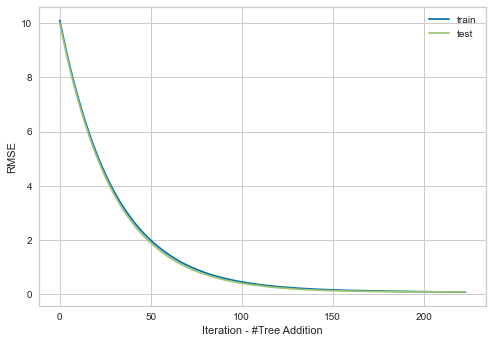

In [355]:
# Plotting Learning Curve
results = xg.evals_result()
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.xlabel('Iteration - #Tree Addition')
pyplot.ylabel('RMSE')
pyplot.show()

Hyperparameter Tuning resulted in merge of Train and text error

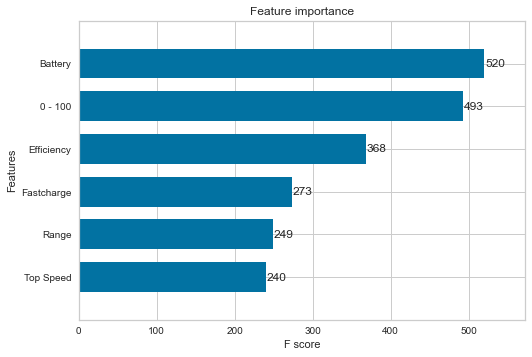

In [356]:
# Feature Importance after the Tuning
_ = plot_importance(xg, height = 0.7)

## Conclusion
1. Ensemble Modeles does not seems to benefit from hyperparameter tuning. Default model performance was better.
2. Boosting Models had higher performance and hyperparameter tuning with K-Fold showed better Results
3. Extreme Gradient Boosting was the optimal due to its performance, optimal learning curve (no sign of overfit) fast training time (The design of the XGB is to make computation faster)